In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scipy.optimize
import warnings

In [3]:
warnings.filterwarnings(action='ignore')

In [4]:
df = pd.read_csv('water_potability 2.csv').fillna(0)
df.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.000000,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,0.000000,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,0.000000,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,0.000000,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [5]:
df.shape

(3276, 10)

Шаг 1. Выберите подвыборку с основными переменными для дальнейшего анализа. Затем для каждой из
них:

In [6]:
df = df[['Hardness', 'ph', 'Solids', 'Organic_carbon']]
df.head(10)

,Hardness,ph,Solids,Organic_carbon
0,204.890455,0.000000,20791.318981,10.379783
1,129.422921,3.716080,18630.057858,15.180013
2,224.236259,8.099124,19909.541732,16.868637
3,214.373394,8.316766,22018.417441,18.436524
4,181.101509,9.092223,17978.986339,11.558279
5,188.313324,5.584087,28748.687739,8.399735
6,248.071735,10.223862,28749.716544,13.789695
7,203.361523,8.635849,13672.091764,12.363817
8,118.988579,0.000000,14285.583854,12.706049
9,227.231469,11.180284,25484.508491,17.927806


In [7]:
df.rename(columns = {'fixed acidity': 'fixed_acidity',
                     'residual sugar' : 'residual_sugar',
                     'total sulfur dioxide' : 'total_sulfur_dioxide'}, inplace = True)
df.head(10)

,Hardness,ph,Solids,Organic_carbon
0,204.890455,0.000000,20791.318981,10.379783
1,129.422921,3.716080,18630.057858,15.180013
2,224.236259,8.099124,19909.541732,16.868637
3,214.373394,8.316766,22018.417441,18.436524
4,181.101509,9.092223,17978.986339,11.558279
5,188.313324,5.584087,28748.687739,8.399735
6,248.071735,10.223862,28749.716544,13.789695
7,203.361523,8.635849,13672.091764,12.363817
8,118.988579,0.000000,14285.583854,12.706049
9,227.231469,11.180284,25484.508491,17.927806


Шаг 2. Вам необходимо сделать непараметрическую оценку плотности распределения в виде
гистограммы и используя функцию плотности ядра

In [8]:
def cut_tails(array):
    array_cut = []
    q75, q25 = np.percentile(array, [75, 25])
    interval = q75 - q25
    
    min_dist = q25 - (1.5 * interval)
    max_dist = q75 + (1.5 * interval)
    
    for data in array:
        if data < max_dist and data > min_dist:
            array_cut.append(data)
    return array_cut

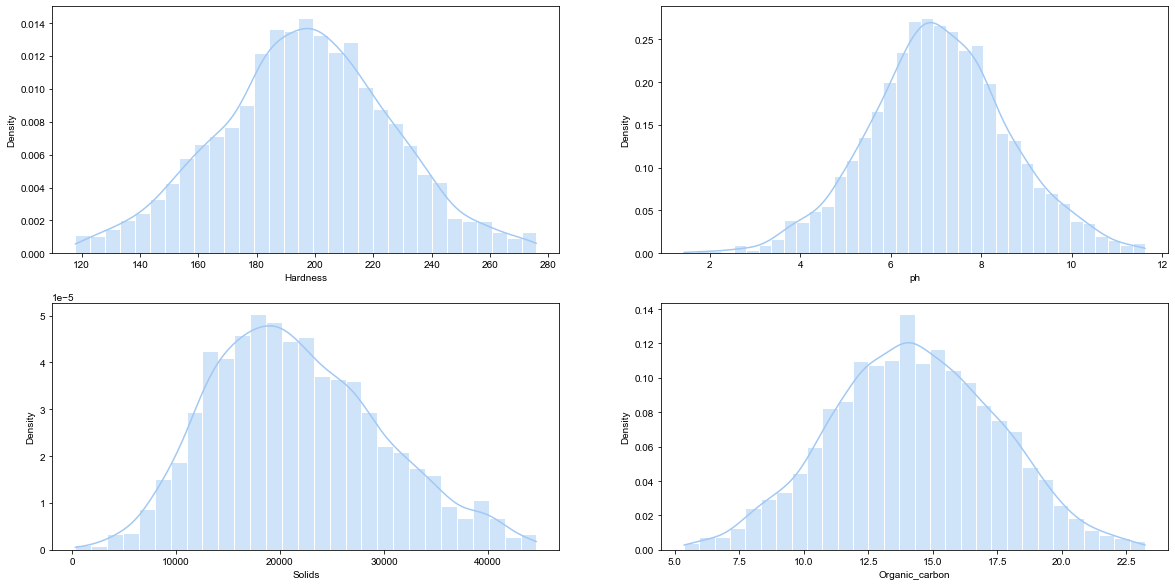

In [9]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid', palette='pastel')

fixed_acidity = sns.histplot(cut_tails(df['Hardness']), ax=ax[0, 0], kde=True, stat='density')
fixed_acidity.set(xlabel='Hardness')

ph = sns.histplot(cut_tails(df['ph']), ax=ax[0, 1], kde=True, stat='density')
ph.set(xlabel='ph')

residual_sugar = sns.histplot(cut_tails(df['Solids']), ax=ax[1, 0], kde=True, stat='density')
residual_sugar.set(xlabel='Solids')

total_sulfur_dioxide = sns.histplot(cut_tails(df['Organic_carbon']), ax=ax[1, 1], kde=True, stat='density')
total_sulfur_dioxide.set(xlabel='Organic_carbon')

plt.show()

Шаг 3. Вам необходимо провести оценку порядковых статистик и представить их в виде “ящиков с усами”.

In [10]:
def return_quantile(array):
    return np.array([
        np.quantile(array, 0.1),
        np.quantile(array, 0.25),
        np.quantile(array, 0.5),
        np.quantile(array, 0.75),
        np.quantile(array, 0.9)
    ])

def plot_box(array, label):
    figure, ax = plt.subplots(2, 1, figsize=(10, 10))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    histplot = sns.histplot(array, ax=ax[0], kde=False, stat='density')
    boxplot = sns.boxplot(array, ax=ax[1], linewidth=0.5)
    
    histplot.set(xlabel=label)
    boxplot.set(xlabel=label)
    
    quantiles = return_quantile(array)
    for quantile in quantiles:
        ax[0].axvline(quantile, color='black', linestyle='--', alpha=0.75)
        ax[1].axvline(quantile, color='black', linestyle='--', alpha=0.75)
    
    plt.show()

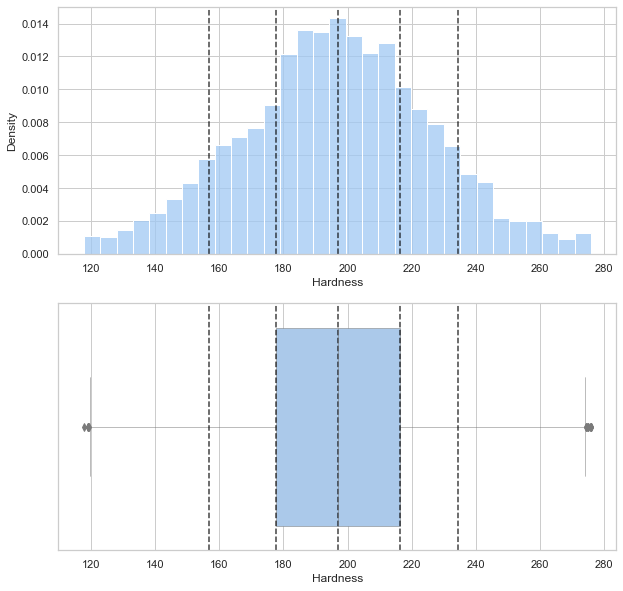

In [11]:
plot_box(cut_tails(df.Hardness), 'Hardness')

In [12]:
print(return_quantile(df.Hardness))
pd.Series(cut_tails(df.Hardness)).describe()

[155.22396411 176.85053788 196.96762686 216.66745621 236.3507074 ]


count    3193.000000
mean      196.507595
std        29.781440
min       117.791230
25%       177.571744
50%       197.049965
75%       216.237975
max       275.886513
dtype: float64

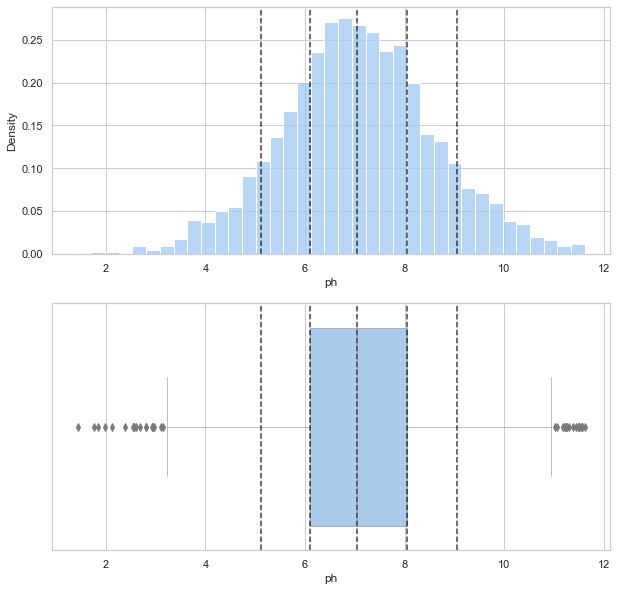

In [13]:
plot_box(cut_tails(df.ph), 'ph')

In [14]:
print(return_quantile(df.ph))
pd.Series(cut_tails(df.ph)).describe()

[0.         5.28314559 6.73524896 7.87004976 8.92504688]


count    2774.000000
mean        7.075595
std         1.550417
min         1.431782
25%         6.095666
50%         7.034491
75%         8.054425
max        11.621140
dtype: float64

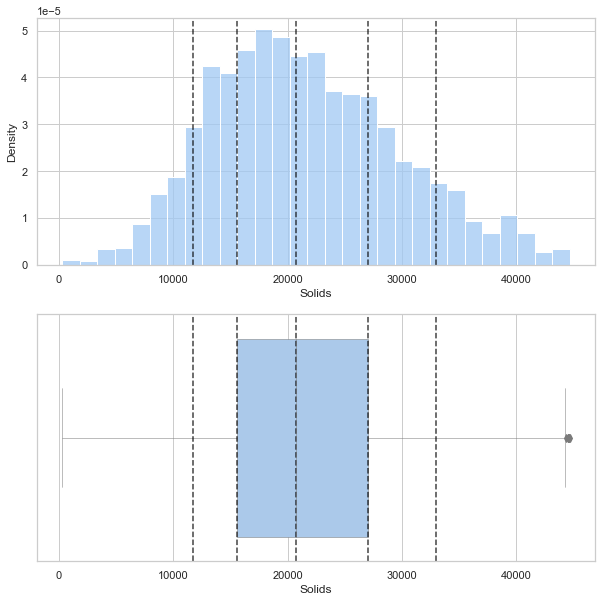

In [15]:
plot_box(cut_tails(df.Solids), 'Solids')

In [16]:
print(return_quantile(df.Solids))
pd.Series(cut_tails(df.Solids)).describe()

[11740.52818947 15666.69029696 20927.83360652 27332.76212744
 33814.9352302 ]


count     3229.000000
mean     21624.156607
std       8196.468649
min        320.942611
25%      15547.186626
50%      20709.279762
75%      27045.929958
max      44652.363872
dtype: float64

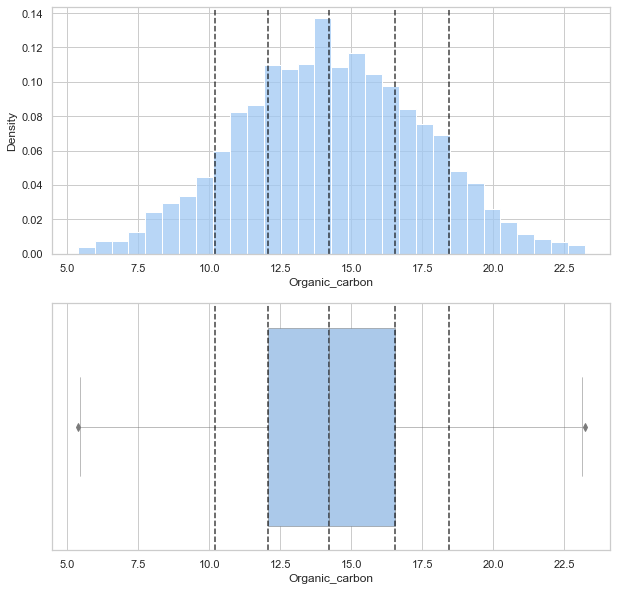

In [17]:
plot_box(cut_tails(df.Organic_carbon), 'Organic_carbon')

In [18]:
print(return_quantile(df.Organic_carbon))
pd.Series(cut_tails(df.Organic_carbon)).describe()

[10.12376538 12.06580133 14.21833794 16.55765154 18.50456709]


count    3251.000000
mean       14.286008
std         3.205598
min         5.362371
25%        12.083032
50%        14.219303
75%        16.541900
max        23.234326
dtype: float64

Шаг 4. Найдите одно или несколько теоретических распределений, которые могли бы описать вашу
выборку на основе результатов непараметрического анализа.

In [19]:
def return_distplot(array, label):
    figure, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    subplot = sns.histplot(array, kde=False, stat='density')
    subplot.set(xlabel=label)
    
    for distribution in ([scipy.stats.norm, scipy.stats.alpha,
                         scipy.stats.beta, scipy.stats.lognorm
                         ]):
        
        x_plot = np.linspace(np.min(array), np.max(array), 100)
        args = distribution.fit(array)
        print('Distribution', type(distribution).__name__, 'arguments:', args)
        y_plot = distribution.pdf(x_plot, *args)
        
        sns.lineplot(x_plot, y_plot, label=type(distribution).__name__)
        plt.legend()

Distribution norm_gen arguments: (196.5075946672014, 29.776775636538307)
Distribution alpha_gen arguments: (17.222180217296305, -324.61483905817784, 8934.432241152113)
Distribution beta_gen arguments: (12.279809435351527, 11.91465379956296, 44.708955586183556, 299.0795254476316)
Distribution lognorm_gen arguments: (0.014543194858788272, -1850.9535830351942, 2047.1658271683173)


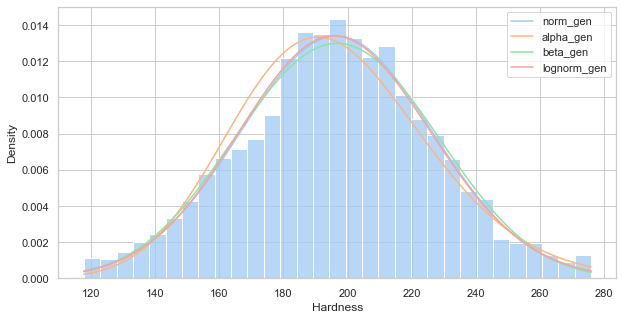

In [20]:
return_distplot(cut_tails(df.Hardness), 'Hardness')

Distribution norm_gen arguments: (7.075594963485487, 1.5501375200276437)
Distribution alpha_gen arguments: (20.549141484536847, -25.348930899603147, 664.4917450357912)
Distribution beta_gen arguments: (12572.346038933421, 4974735.420981089, -166.96421800028577, 69039.66791207783)
Distribution lognorm_gen arguments: (0.015191187297296523, -94.93437489067958, 101.9950066667106)


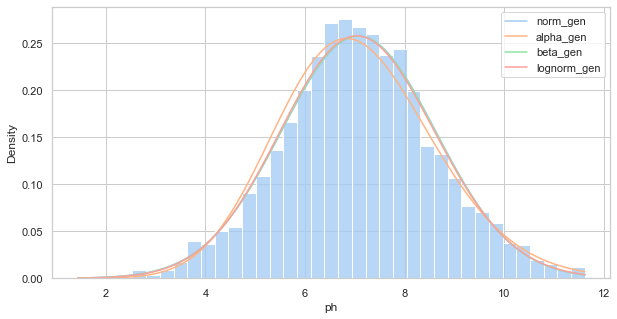

In [21]:
return_distplot(cut_tails(df.ph), 'ph')

Distribution norm_gen arguments: (21624.156606756114, 8195.19935478122)
Distribution alpha_gen arguments: (2.2092022829264613, -6844.7689407283415, 57867.39588700578)
Distribution beta_gen arguments: (5.618376303242448, 11.850682537411835, -2537.042661416989, 75139.01906345192)
Distribution lognorm_gen arguments: (0.1613087706169109, -29064.126529596186, 50034.18799069272)


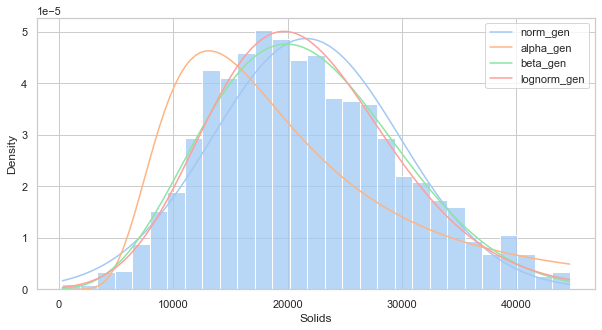

In [22]:
return_distplot(cut_tails(df.Solids), 'Solids')

Distribution norm_gen arguments: (14.286007565498405, 3.2051046813744346)
Distribution alpha_gen arguments: (19.383893793315494, -47.548023182814944, 1195.2765783152663)
Distribution beta_gen arguments: (7.845309522281461, 7.998063777648897, 1.2518859304143548, 26.322275615146047)
Distribution lognorm_gen arguments: (0.018911675793696722, -155.53426777705738, 169.78988141210527)


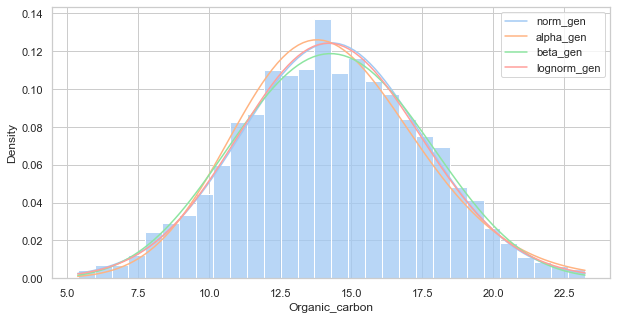

In [23]:
return_distplot(cut_tails(df.Organic_carbon), 'Organic_carbon')

Шаг 5. Оценить параметры выбранных распределений, используя методы максимального правдоподобия
и метод наименьших квадратов.

In [51]:
array = cut_tails(df.Hardness)
mle = scipy.stats.norm.fit(array, method='MLE')

print('Distribution', type(scipy.stats.norm).__name__, 'arguments:', mle)

def function(x, a, b):
    return getattr(scipy.stats.distributions, 'norm').pdf(x, a, b)

xdata, ydata = np.histogram(array, bins=10, density=True)
ls, _ = scipy.optimize.curve_fit(function, xdata=xdata[:10], ydata=ydata[:10], method='lm', maxfev=5000)

print('Maximum Likelihood Estimation: {:.3f}, {:.3f}'.format(mle[0], mle[1]))
print('LS Method: {:.3f}, {:.3f}'.format(ls[0], ls[1]))

Distribution norm_gen arguments: (196.5075946672014, 29.776775636538307)
Maximum Likelihood Estimation: 196.508, 29.777
LS Method: 0.004, 0.003


In [52]:
array = cut_tails(df.ph)
mle = scipy.stats.norm.fit(array, method='MLE')

print('Distribution', type(scipy.stats.norm).__name__, 'arguments:', mle)

def function(x, a, c):
    return getattr(scipy.stats.distributions, 'norm').pdf(x, a, c)

xdata, ydata = np.histogram(array, bins=10, density=True)
ls, _ = scipy.optimize.curve_fit(function, xdata=xdata[:10], ydata=ydata[:10], method='lm', maxfev=5000)

print('Maximum Likelihood Estimation: {:.3f}, {:.3f}'.format(mle[0], mle[1]))
print('LS Method: {:.3f}, {:.3f}'.format(ls[0], ls[1]))

Distribution norm_gen arguments: (7.075594963485487, 1.5501375200276437)
Maximum Likelihood Estimation: 7.076, 1.550
LS Method: 0.093, 0.077


In [55]:
array = cut_tails(df.Solids)
mle = scipy.stats.beta.fit(array, method='MLE')

print('Distribution', type(scipy.stats.beta).__name__, 'arguments:', mle)

def function(x, a, c):
    return getattr(scipy.stats.distributions, 'beta').pdf(x, a, c)

xdata, ydata = np.histogram(array, bins=10, density=True)
ls, _ = scipy.optimize.curve_fit(function, xdata=xdata[:10], ydata=ydata[:10], method='lm', maxfev=5000)

print('Maximum Likelihood Estimation: {:.3f}, {:.3f}'.format(mle[0], mle[1]))
print('LS Method: {:.3f}, {:.3f}'.format(ls[0], ls[1]))

Distribution beta_gen arguments: (5.618376303242448, 11.850682537411835, -2537.042661416989, 75139.01906345192)
Maximum Likelihood Estimation: 5.618, 11.851
LS Method: 1.789, 64390.716


In [56]:
array = cut_tails(df.Organic_carbon)
mle = scipy.stats.norm.fit(array, method='MLE')

print('Distribution', type(scipy.stats.norm).__name__, 'arguments:', mle)

def function(x, a, c):
    return getattr(scipy.stats.distributions, 'norm').pdf(x, a, c)

xdata, ydata = np.histogram(array, bins=10, density=True)
ls, _ = scipy.optimize.curve_fit(function, xdata=xdata[:10], ydata=ydata[:10], method='lm', maxfev=5000)

print('Maximum Likelihood Estimation: {:.3f}, {:.3f}'.format(mle[0], mle[1]))
print('LS Method: {:.3f}, {:.3f}'.format(ls[0], ls[1]))

Distribution norm_gen arguments: (14.286007565498405, 3.2051046813744346)
Maximum Likelihood Estimation: 14.286, 3.205
LS Method: 0.054, 0.040


Шаг 6. Проверьте оцененные параметры с помощью графика квантиль-квантиль (QQ).

In [28]:
def return_biplot(array, distribution):
    figure, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    scipy.stats.probplot(array, dist=distribution, sparams=(args), plot=ax)
    
    ax.get_lines()[0].set_marker('o')
    
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)
    
    plt.show()

Distribution norm_gen arguments: (196.5075946672014, 29.776775636538307)


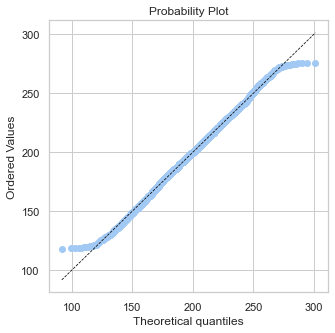

In [58]:
return_biplot(cut_tails(df.Hardness), distribution=scipy.stats.norm)

Distribution norm_gen arguments: (7.075594963485487, 1.5501375200276437)


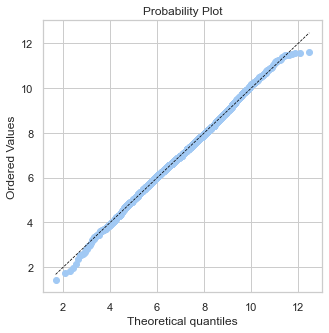

In [30]:
return_biplot(cut_tails(df.ph), distribution=scipy.stats.norm)

Distribution beta_gen arguments: (5.618376303242448, 11.850682537411835, -2537.042661416989, 75139.01906345192)


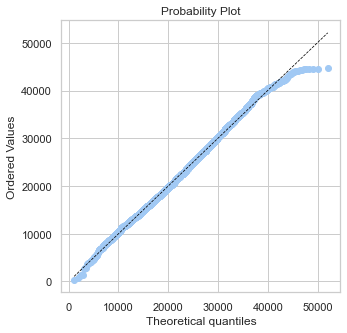

In [31]:
return_biplot(cut_tails(df.Solids), distribution=scipy.stats.beta)

Distribution norm_gen arguments: (14.286007565498405, 3.2051046813744346)


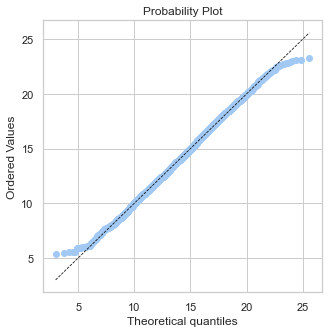

In [32]:
return_biplot(cut_tails(df.Organic_carbon), distribution=scipy.stats.norm)

Шаг 7. Оценить достоверность подогнанных распределений, используя не менее 2 статистических тестов.

In [33]:
def return_test(array, distribution, cdf):
    args = distribution.fit(array)
    
    kstest = scipy.stats.kstest(array, cdf=cdf, args=args).pvalue
    cramervonmises = scipy.stats.cramervonmises(array, cdf=cdf, args=args).pvalue
    
    print('Kolmogorov-Smirnov Test: {:.5f}'.format(kstest))
    print('Cramer–Von Mises Test: {:.5f}'.format(cramervonmises))

In [34]:
return_test(cut_tails(df.Hardness),
            distribution=scipy.stats.norm, cdf = 'norm') 

Kolmogorov-Smirnov Test: 0.57179
Cramer–Von Mises Test: 0.58354


In [35]:
return_test(cut_tails(df.ph), distribution=scipy.stats.norm, cdf='norm')

Kolmogorov-Smirnov Test: 0.50853
Cramer–Von Mises Test: 0.29004


In [36]:
return_test(cut_tails(df.Solids), distribution=scipy.stats.beta, cdf='beta')

Kolmogorov-Smirnov Test: 0.08257
Cramer–Von Mises Test: 0.20369


In [37]:
return_test(cut_tails(df.Organic_carbon), distribution=scipy.stats.norm, cdf='norm')

Kolmogorov-Smirnov Test: 0.60844
Cramer–Von Mises Test: 0.56942


Шаг 8. Используя одномерные параметрические распределения, которые были подобраны, выполните
семплирование СВ. Используйте для этого не менее 2 различных методов семплирования.

In [38]:
def inverse_transform_sampling(array, distribution):
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    data = np.random.uniform(size=len(array))
    sample = distribution(*args)
    sample= sample.ppf(data)
    return sample

def custom_sampling(array, distribution):
    args = distribution.fit(array)
    sample = distribution.rvs(*args, size=len(array))
    return sample

def return_cdf(array):
    bins, x = np.histogram(array, bins=100)
    probas = bins / sum(bins)
    y = np.cumsum(probas)
    return x[:100], y[:100]

Hardness
Distribution norm_gen arguments: (196.5075946672014, 29.776775636538307)
ph
Distribution norm_gen arguments: (7.075594963485487, 1.5501375200276437)
Solids
Distribution beta_gen arguments: (5.618376303242448, 11.850682537411835, -2537.042661416989, 75139.01906345192)
Organic_carbon
Distribution norm_gen arguments: (14.286007565498405, 3.2051046813744346)


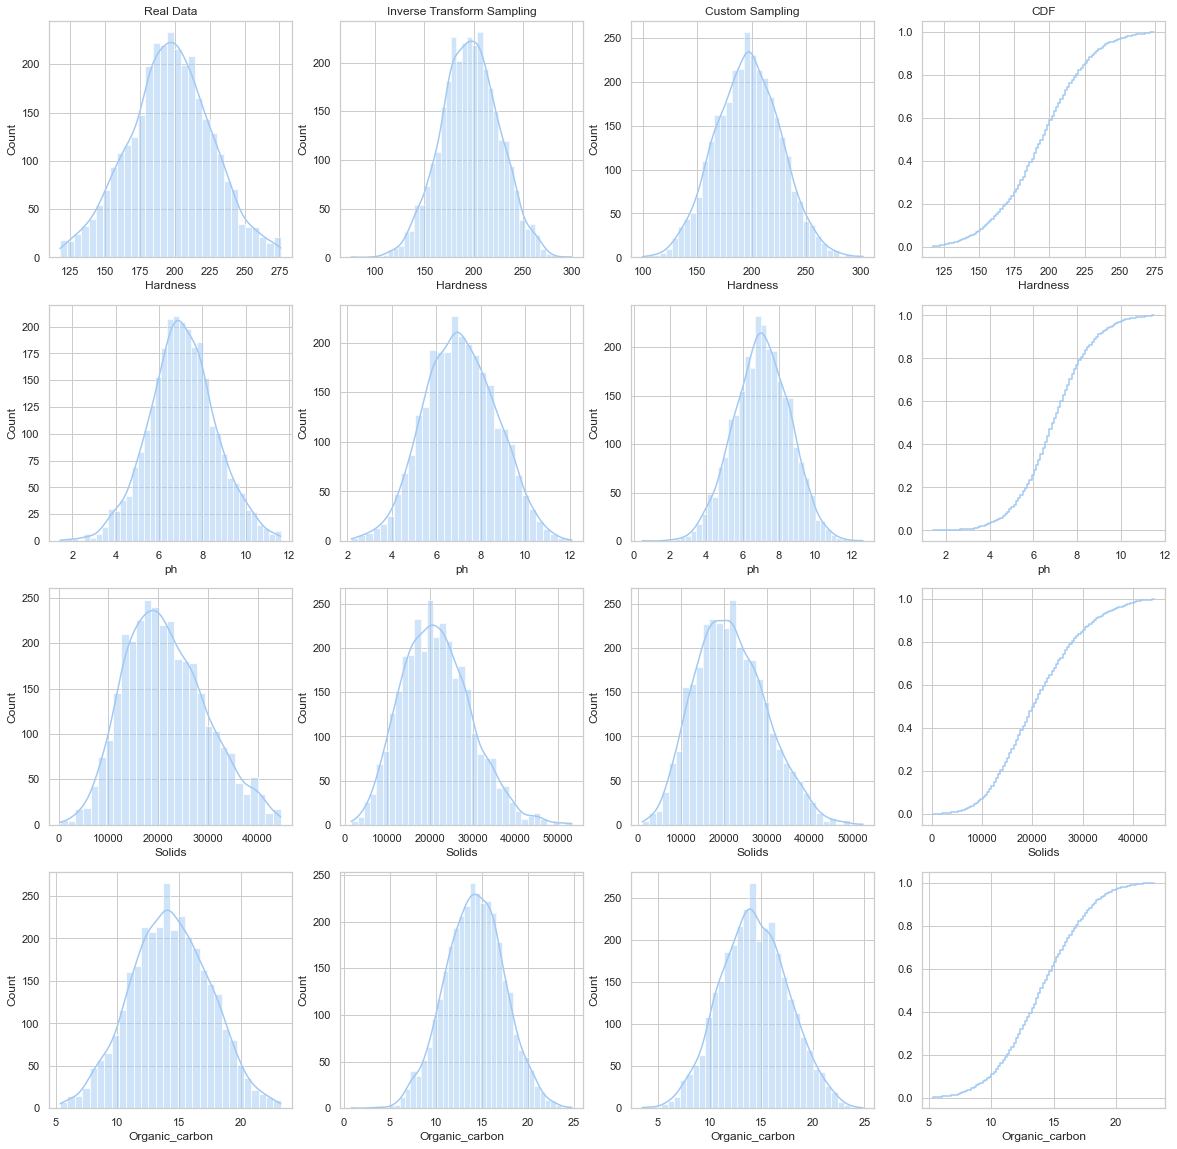

In [47]:
figure, ax = plt.subplots(4, 4, figsize=(20, 20))
sns.set_theme(style='whitegrid', palette='pastel')

print('Hardness')
sns.histplot(cut_tails(df.Hardness), ax=ax[0, 0], kde=True)
sns.histplot(inverse_transform_sampling(cut_tails(df.Hardness), distribution=scipy.stats.norm), ax=ax[0, 1], kde=True)
sns.histplot(custom_sampling(cut_tails(df.Hardness), distribution=scipy.stats.norm), ax=ax[0, 2], kde=True)
sns.lineplot(return_cdf(cut_tails(df.Hardness))[0], return_cdf(cut_tails(df.Hardness))[1], ax=ax[0, 3], drawstyle='steps-pre')

print('ph')
sns.histplot(cut_tails(df.ph), ax=ax[1, 0], kde=True)
sns.histplot(inverse_transform_sampling(cut_tails(df.ph), distribution=scipy.stats.norm), ax=ax[1, 1], kde=True)
sns.histplot(custom_sampling(cut_tails(df.ph), distribution=scipy.stats.norm), ax=ax[1, 2], kde=True)
sns.lineplot(return_cdf(cut_tails(df.ph))[0], return_cdf(cut_tails(df.ph))[1], ax=ax[1, 3], drawstyle='steps-pre')

print('Solids')
sns.histplot(cut_tails(df.Solids), ax=ax[2, 0], kde=True)
sns.histplot(inverse_transform_sampling(cut_tails(df.Solids), distribution=scipy.stats.beta), ax=ax[2, 1], kde=True)
sns.histplot(custom_sampling(cut_tails(df.Solids), distribution=scipy.stats.beta), ax=ax[2, 2], kde=True)
sns.lineplot(return_cdf(cut_tails(df.Solids))[0], return_cdf(cut_tails(df.Solids))[1], ax=ax[2, 3], drawstyle='steps-pre')

print('Organic_carbon')
sns.histplot(cut_tails(df.Organic_carbon), ax=ax[3, 0], kde=True)
sns.histplot(inverse_transform_sampling(cut_tails(df.Organic_carbon), distribution=scipy.stats.norm), ax=ax[3, 1], kde=True)
sns.histplot(custom_sampling(cut_tails(df.Organic_carbon), distribution=scipy.stats.beta), ax=ax[3, 2], kde=True)
sns.lineplot(return_cdf(cut_tails(df.Organic_carbon))[0], return_cdf(cut_tails(df.Organic_carbon))[1], ax=ax[3, 3], drawstyle='steps-pre')

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Inverse Transform Sampling')
ax[0, 2].set_title('Custom Sampling')
ax[0, 3].set_title('CDF')

ax[0, 0].set(xlabel='Hardness')
ax[0, 1].set(xlabel='Hardness')
ax[0, 2].set(xlabel='Hardness')
ax[0, 3].set(xlabel='Hardness')
ax[1, 0].set(xlabel='ph')
ax[1, 1].set(xlabel='ph')
ax[1, 2].set(xlabel='ph')
ax[1, 3].set(xlabel='ph')
ax[2, 0].set(xlabel='Solids')
ax[2, 1].set(xlabel='Solids')
ax[2, 2].set(xlabel='Solids')
ax[2, 3].set(xlabel='Solids')
ax[3, 0].set(xlabel='Organic_carbon')
ax[3, 1].set(xlabel='Organic_carbon')
ax[3, 2].set(xlabel='Organic_carbon')
ax[3, 3].set(xlabel='Organic_carbon')

plt.show()